### Goal

Analyse the results from `2_lm_geneeffect_simulated_and_gtex.ipynb`. 

### TODO
1. Distribution of MSE per gene (Are there tissues (or genes or individual) for which the model makes larger errors on average?
 - 1.1 List of genes with low mse - what are the genes for which the model fitted well.
 - 1.2 List of genes which varies a lot across individuals: - compute the CV as in the paper [Paper](https://medcraveonline.com/MOJPB/MOJPB-06-00200.pdf)
 - 1.3 Correlation between Pred and Observed for genes highly enriched in muscle skeletal according to GTEx top 50 (pick only the tissue specific genes); check also [Protein Atlas](https://www.proteinatlas.org/search/tissue_specificity_rna:skeletal%20muscle;elevated%20AND%20sort_by:tissue%20specific%20score%20AND%20show_columns:groupenriched) 
    - Prediction and Observed for top 10 indiv / top 10 genes / random sampling from genes
    - MSE by tissue, gene, and individual -> distribution of average MSE by tissue, by gene and by the individual. 
      
 - 1.4 Genes distribution per individual
 
2. Performance summary of different models for top 3 Tissues

### Conclusions
1. The computation was done for the `coordinative fitting model` using the `mse` as loss function 
  - 1.1 By choosing the genes with low MSE between Prediction and Observed we do see that overall the predictions are in [-1, 1] and performs poorly especially for |FC| > 1.
  - 1.2. The predictions do not capture the variation between individuals 
  - 1.2. Around 8700 have in the true dataset a CV < 0.5. These are the genes for which the prediction should be good
  - 1.3. For the top 50 Muscle specific expressed gene we do observe that the model cannot capture the FC spectrum.
  - 1.5.2 Nicely predicted genes:
        - RPS4Y1  ('ENSG00000129824.15')
        - FKBP5 ('ENSG00000096060.14')
        - GSTM1 ('ENSG00000134184.12')
        - DDX3Y ('ENSG00000067048.16')


2. The different models do not show any improvement. The data is strongly non-linear. Instead of using the PCA, the SOM or Autoencoder would be a more suitable approach to do the dimensionality reduction for non-linear data.

3. Filter the Gene Set (analysis was performed only of the muscle dataset):
    - Large variation can occur also due to small TPMs.
    - Remove genes which do not have a HGNC ID or Uniprot ID in order to avoid FP protein-coding genes annotated in GENCODE. This means the gene its curated and has a protein product
    - We cannot remove genes with low counts because the gene might be specific for other tissues


4. Suggestion to compute the metrics:
    - compute metrics for genes which have a CV <= 5 (~8-9000) genes

In [8]:
from joblib import dump, load
import numpy as np
import pandas as pd

from rep import models as m
from rep import constants as cst
from rep import linear_regression as lr
from rep import preprocessing_new as prep

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## 0. Prediction from Blood to Muscle

In [12]:
path_models = "/s/project/rep/processed/models/linear_regression/"

In [4]:
model = load(f'{path_models}blood2muscle_skeletal_model4.joblib')
# model = load(f'{path_models}blood2muscle_skeletal_model4_new.joblib')

In [5]:
(y_blood_train, y_muscle_train, meta_train, P_train, Q, n_genes_train, n_indiv_train), (y_blood_valid, y_muscle_valid, meta_valid, P_valid, Q, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input('Muscle - Skeletal')

(331, 19932)


In [6]:
path = "/s/project/rep/"

In [7]:
features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
gtex = prep.RepAnnData.read_h5ad(features_file)

In [8]:
y_blood_valid.shape, y_muscle_valid.shape, P_valid.shape, Q.shape, n_genes_valid, n_indiv_valid, meta_valid.shape

((74, 19932), (74, 19932), (74, 10), (19932, 10), 19932, 74, (74, 11))

In [9]:
y_pred_valid = m.predict_model4(model, y_blood_valid, P_valid, Q, n_genes_valid, n_indiv_valid)
y_pred_train = m.predict_model4(model, y_blood_train, P_train, Q, n_genes_train, n_indiv_train)

In [10]:
y_pred_train = y_pred_train.astype(np.float32)
y_pred_valid = y_pred_valid.astype(np.float32)

In [11]:
y_pred_train.shape, y_pred_valid.shape

((189, 19932), (74, 19932))

In [9]:
def filter_data(y_pred_, y_true_, individual_list, gene_list, anno_genes, meta_samples):
    
    index_indiv = np.array(np.where(meta_samples['Individual'].isin(individual_list))[0],dtype=np.int).tolist()
    index_genes = np.array(np.where(anno_genes['gene_id'].isin(gene_list))[0], dtype=np.int).tolist()
    
    y_pred_slice = y_pred_[index_indiv,:][:,index_genes]
    y_true_slice = y_true_[index_indiv,:][:,index_genes]
    
    indiv_sorted = meta_samples[meta_samples['Individual'].isin(individual_list)]
    gene_sorted = anno_genes[anno_genes['gene_id'].isin(gene_list)]
    indiv_sorted = indiv_sorted.iloc[np.repeat(np.arange(len(indiv_sorted)), len(index_genes))]['Individual'].tolist()
    gene_sorted = gene_sorted.iloc[np.tile(np.arange(len(gene_sorted)), len(index_indiv))]['symbol'].tolist()
        
    data = pd.DataFrame({'y_true':y_true_slice.flatten(), 
                         'y_pred':y_pred_slice.flatten(),
                         'Individual':indiv_sorted,
                         'Gene':gene_sorted})
    
    return data

In [46]:
def plot_expression_correlation_per_gene(df, title, width_ = 14, height_ = 5, min_ = None, max_ = None):
    
    if min_ is None or max_ is None: 
        min_ = min(min(df['y_true']), min(df['y_pred']))
        max_ = max(max(df['y_true']), max(df['y_pred']))
    fig = (
        ggplot(df, aes(x='y_pred', y='y_true')) + 
        geom_bin2d(bins = 40) +
        theme_bw() + 
        facet_wrap('~Gene', ncol = 6) + 
        theme(figure_size = (width_, height_)) + 
        ggtitle(title) + 
        xlim(min_, max_) + 
        ylim(min_, max_))
    return fig

def plot_expression_correlation_per_individual(df, title, width_ = 14, height_ = 5, min_ = None, max_ = None):
    
    if min_ is None or max_ is None: 
        min_ = min(min(df['y_true']), min(df['y_pred']))
        max_ = max(max(df['y_true']), max(df['y_pred']))
    fig = (
        ggplot(df, aes(x='y_pred', y='y_true')) + 
        geom_bin2d(bins = 40) +
        theme_bw() + 
        facet_wrap('~Individual', ncol = 6) + 
        theme(figure_size = (width_, height_)) + 
        ggtitle(title) + 
        xlim(min_, max_) + 
        ylim(min_, max_))
    return fig

In [47]:
def mse_per_gene(y_pred_, y_true_, gene_anno):
    dict_mse = {}
    list_mse = []
    for gene in range(y_pred_.shape[1]):
        err = mean_squared_error(y_pred_[:,gene], y_true_[:,gene])
        dict_mse[gene_anno.iloc[gene,:]['gene_id']] = {}
        dict_mse[gene_anno.iloc[gene,:]['gene_id']]['mse'] = err
        dict_mse[gene_anno.iloc[gene,:]['gene_id']]['true_mean'] = np.mean(y_true_[:,gene])
        dict_mse[gene_anno.iloc[gene,:]['gene_id']]['pred_mean'] = np.mean(y_pred_[:,gene])
        dict_mse[gene_anno.iloc[gene,:]['gene_id']]['true_var'] = np.var(y_true_[:,gene])
        dict_mse[gene_anno.iloc[gene,:]['gene_id']]['pred_var'] = np.var(y_pred_[:,gene])
        list_mse.append(err)
    return dict_mse, list_mse

# coefficient of variation using the log2 TPM - log-normal distributed variable
def cv_per_gene(y_true_, gene_anno):
    cv = np.sqrt(np.power(2, np.log(2)*np.var(y_true_, axis = 0)) - 1)
    return pd.DataFrame(data = {'coef_var' : cv,
                                'mean': np.mean(y_true_, axis = 0),
                                'gene_id' : gene_anno['gene_id'],
                                'symbol' : gene_anno['symbol']})

In [48]:
def repstr(string, length):
    return (string * length)[0:length]

def plot_distribution(mse_train_, mse_valid_):
    
    df = pd.DataFrame(data={'mse':mse_train_,'type':repstr('train',len(mse_train_))})
    df = df.append(pd.DataFrame(data={'mse':mse_valid_,'type':repstr('valid',len(mse_valid_))}), ignore_index=True)
    
    fig = (
          ggplot(df, aes(x='mse',fill='type')) + 
          geom_density(alpha=0.4)
    )
    return fig

### 0.1 Input / Ouput correlation

In [16]:
data = pd.DataFrame(data={'blood':y_blood_train[:,:3].flatten(),
       'muscle':y_muscle_train[:,:3].flatten(),
       'gene':np.tile(gtex.var.iloc[:3]['symbol'].tolist(),y_blood_train.shape[0])})

In [ ]:
fig = plt.figure(1, figsize=(8, 14), frameon=False, dpi=100)
fig.add_axes([0, 0, 1, 1])
ax = plt.gca()

corners = ((0, 0), (10, 10))
ax.update_datalim(corners)

g = sns.FacetGrid(data, row="blood", col="muscle")

In [ ]:
g.map(sns.scatterplot, "blood", "muscle", color=".3")

## 1. Distribution of MSE per gene

In [17]:
mse_valid_dict, mse_valid_list = mse_per_gene(y_pred_valid, y_muscle_valid, gtex.genes)

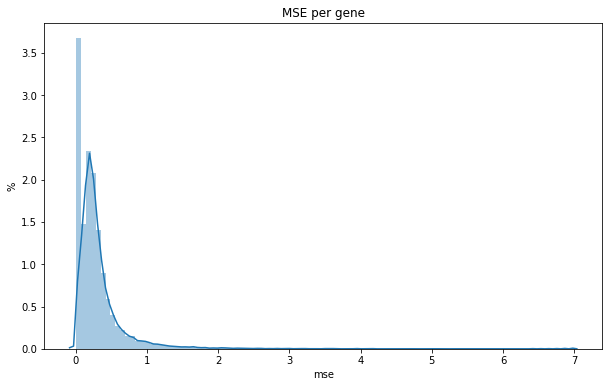

In [18]:
ax = sns.distplot(mse_valid_list,bins=100)
plt.title("MSE per gene")
plt.xlabel("mse")
plt.ylabel("%")
fig = plt.gcf()
fig.set_size_inches(10, 6)

#### 1.1 List of genes with low mse

These are the genes which have a mse < 0.1 between predicted and observed in the validation dataset.
Manual checking of these genes in Human Atlas and GTEx, we conclude that these genes are expressed in all tissues. 
We do observe that the TPM of these specific genes in Muscle tipically is higher as in Blood. 
 - KRTAP22-2 (ENSG00000206106) is a gene only expressed in testis, but we predict all over.
 - DEFB130 (ENSG00000233050) no expression in any tissue


In [30]:
good_predicted_genes = [gene for gene in mse_valid_dict if abs(mse_valid_dict[gene]['mse']) < 0.005]
len(good_predicted_genes)

1388

In [37]:
df_valid = filter_data(y_pred_valid, y_muscle_valid, meta_valid['Individual'].drop_duplicates().tolist(), good_predicted_genes[:30], gtex.genes, meta_valid)
df_train = filter_data(y_pred_train, y_muscle_train, meta_train['Individual'].drop_duplicates().tolist(), good_predicted_genes[:30], gtex.genes, meta_train)

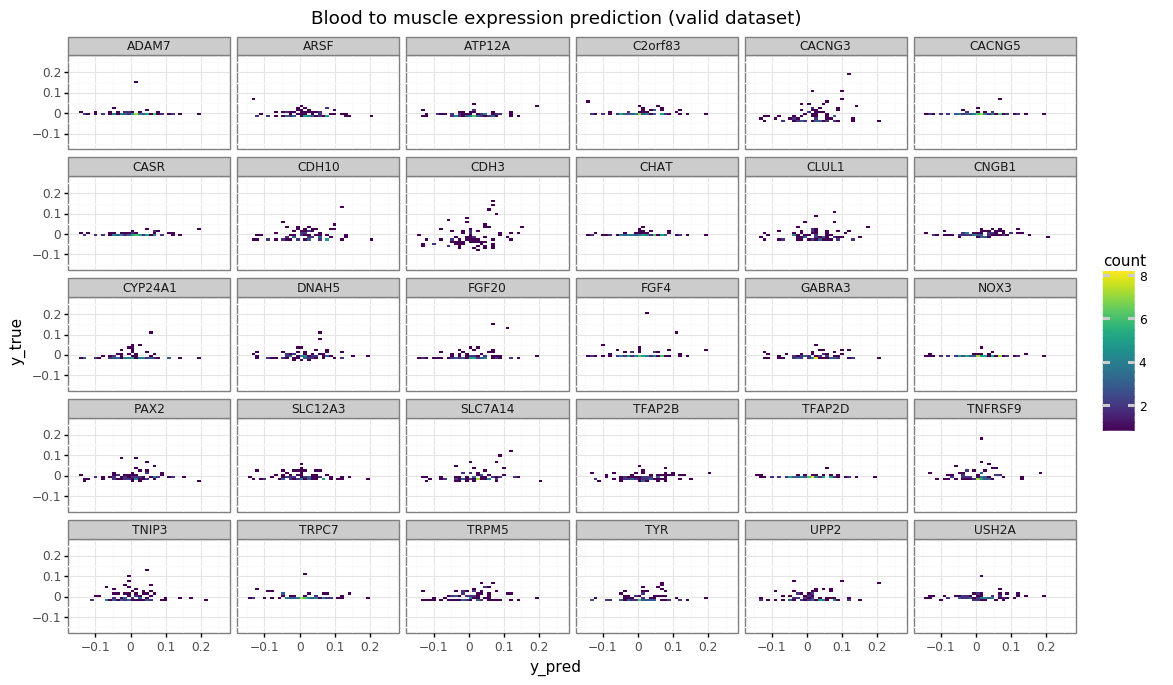

<ggplot: (-9223363268176603774)>

In [44]:
plot_expression_correlation_per_gene(df_valid,'Blood to muscle expression prediction (valid dataset)', width_=13, height_= 7.5)

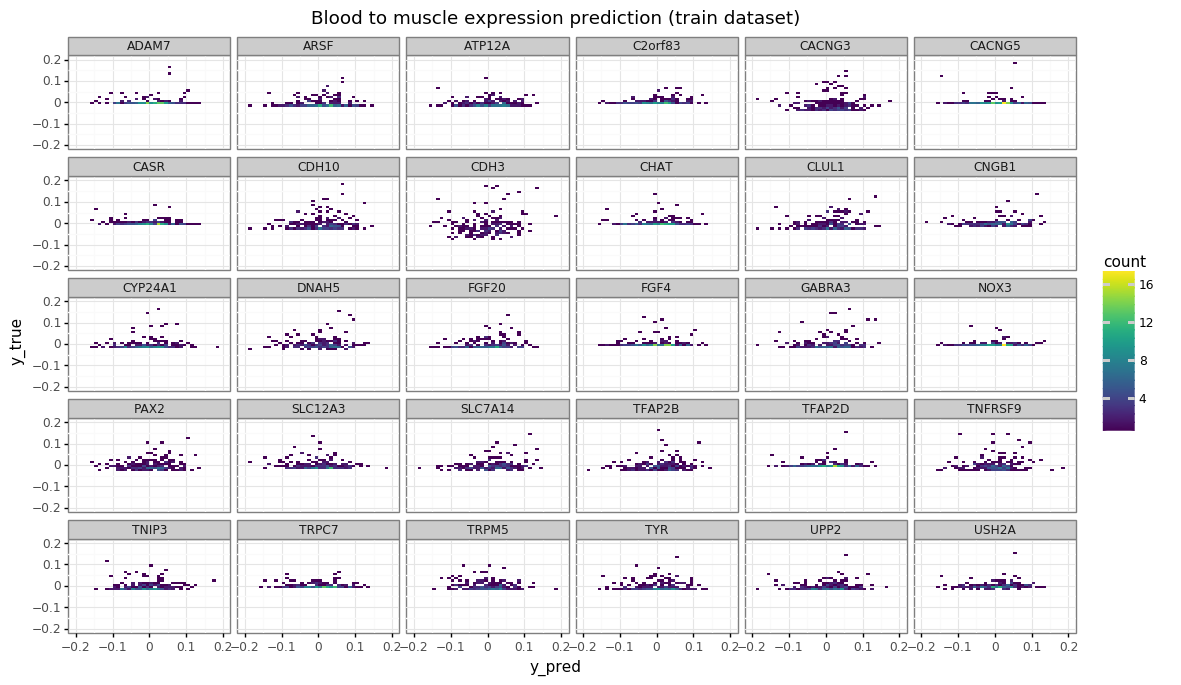

<ggplot: (-9223363268176471310)>

In [46]:
plot_expression_correlation_per_gene(df_train,'Blood to muscle expression prediction (train dataset)', width_=13, height_= 7.5,min_ = -0.2, max_ = 0.2)

### Old plots

In [17]:
df_valid = filter_data(y_pred_valid, y_muscle_valid, meta_valid['Individual'].drop_duplicates().tolist(), good_predicted_genes[:-6aa], gtex.genes, meta_valid)
df_train = filter_data(y_pred_train, y_muscle_train, meta_train['Individual'].drop_duplicates().tolist(), good_predicted_genes[:-6], gtex.genes, meta_train)

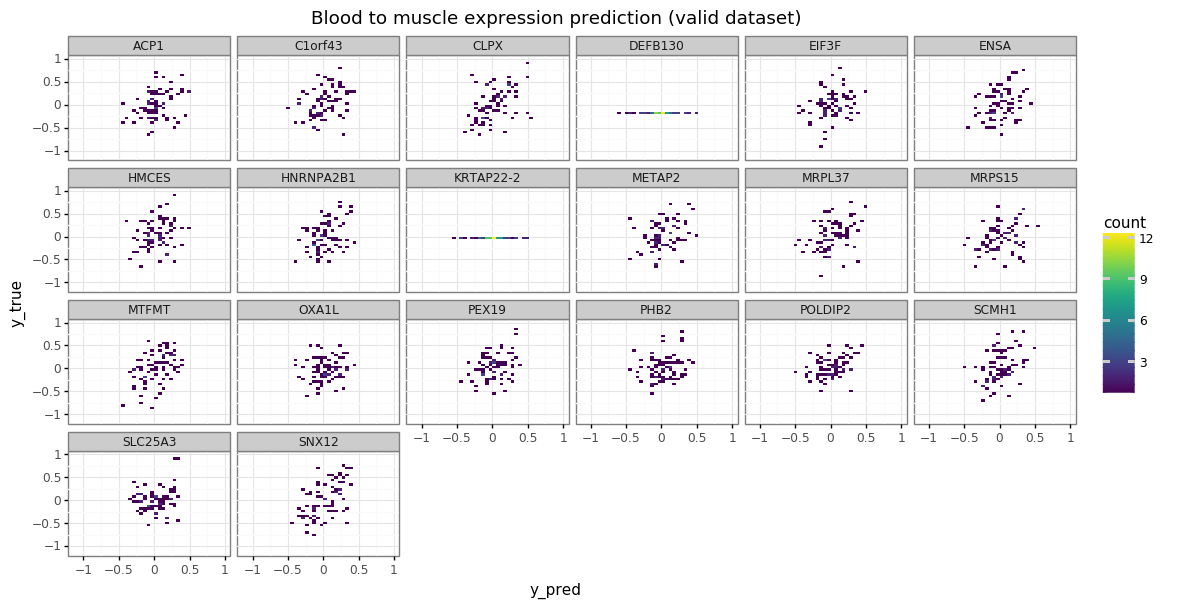

<ggplot: (8761136776880)>

In [20]:
plot_expression_correlation_per_gene(df_valid,'Blood to muscle expression prediction (valid dataset)', width_=13, height_= 6.5)

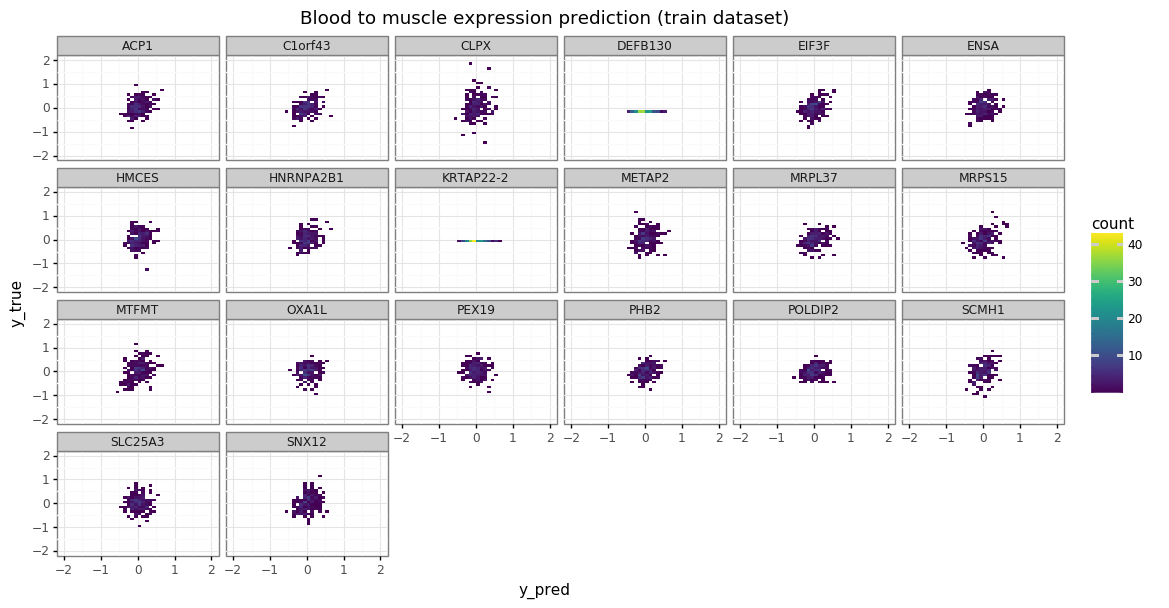

<ggplot: (-9223363275673556683)>

In [21]:
plot_expression_correlation_per_gene(df_train,'Blood to muscle expression prediction (train dataset)', width_=13, height_= 6.5, max_ = 2, min_ = -2)

<br/>

### 1.2 List of genes which varies a lot across individuals: - compute the Coefficient of variation
We know that the $CV[X] = \frac{\sigma[X]}{\mu[X]}$, where X = TPM, random variable neg-binomial distributed. 
For the $log_2(TPM)$, we define $CV[log_2(TPM)] = \sqrt{2^{ln{(2)}\sigma^2} - 1} $

- We observe > 3000 which habe the CV > 10. These are mostly genes not expressed in blood
- 500 genes have a CV [4, 10] 
- 8700 genes with a CV [0.15, 0.5]

In [47]:
coef_variation = cv_per_gene(y_muscle_train, gtex.genes)
coef_variation_predicted = cv_per_gene(y_pred_train, gtex.genes)

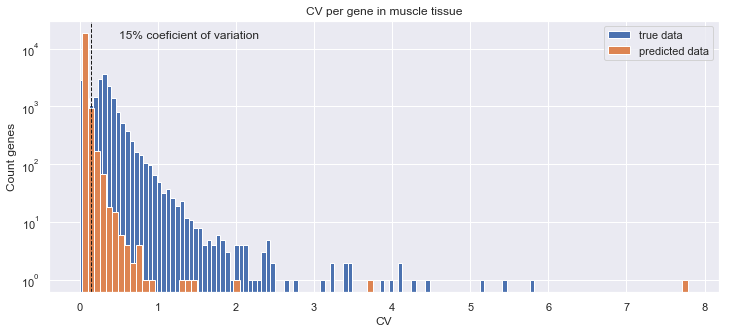

In [48]:
sns.set()
f, ax = plt.subplots(1, 1)

# true data
ax.hist(coef_variation[coef_variation['coef_var']<=10]['coef_var'], bins=100, label = 'true data')
plt.title("CV per gene in muscle tissue")
plt.xlabel("CV")
plt.ylabel("Count genes")
plt.yscale("log")

# add vertical line
ax.axvline(0.15, color='k', linestyle='dashed', linewidth=1)
plt.text(0.5,15000,'15% coeficient of variation')
fig = plt.gcf()
fig.set_size_inches(12, 5)

# predicted data
ax.hist(coef_variation_predicted[coef_variation_predicted['coef_var']<=10]['coef_var'], bins=100, label = 'predicted data')

ax.legend()
plt.show()

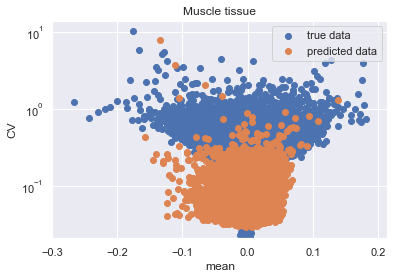

In [49]:
f, ax = plt.subplots(1, 1)

# true data
ax.scatter(coef_variation['mean'], coef_variation['coef_var'], label = 'true data')
plt.title("Muscle tissue")
plt.xlabel("mean")
plt.ylabel("CV")
plt.yscale("log")
# predicted data
ax.scatter(coef_variation_predicted['mean'], coef_variation_predicted['coef_var'],  label = 'predicted data')

ax.legend()
plt.show()

### Old plots

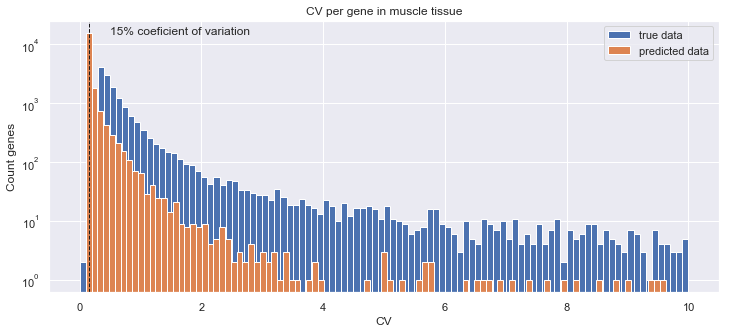

In [86]:
sns.set()
f, ax = plt.subplots(1, 1)

# true data
ax.hist(coef_variation[coef_variation['coef_var']<=10]['coef_var'], bins=100, label = 'true data')
plt.title("CV per gene in muscle tissue")
plt.xlabel("CV")
plt.ylabel("Count genes")
plt.yscale("log")

# add vertical line
ax.axvline(0.15, color='k', linestyle='dashed', linewidth=1)
plt.text(0.5,15000,'15% coeficient of variation')
fig = plt.gcf()
fig.set_size_inches(12, 5)

# predicted data
ax.hist(coef_variation_predicted[coef_variation_predicted['coef_var']<=10]['coef_var'], bins=100, label = 'predicted data')

ax.legend()
plt.show()

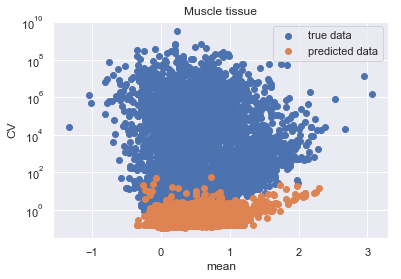

In [85]:
f, ax = plt.subplots(1, 1)

# true data
ax.scatter(coef_variation['mean'], coef_variation['coef_var'], label = 'true data')
plt.title("Muscle tissue")
plt.xlabel("mean")
plt.ylabel("CV")
plt.yscale("log")
# predicted data
ax.scatter(coef_variation_predicted['mean'], coef_variation_predicted['coef_var'],  label = 'predicted data')

ax.legend()
plt.show()

### 1.2.1 Outlier genes (high CV)

In [50]:
# genes with CV [4,10]
high_variation_genes = coef_variation[(coef_variation['coef_var']<=10) & (coef_variation['coef_var']>=4)]['gene_id'].tolist()

In [51]:
# genes with CV [0.15, 0.5]
len(coef_variation[(coef_variation['coef_var']<=0.5) & (coef_variation['coef_var']>=0.15)])

12757

In [52]:
# genes with CV <= 5
len(coef_variation[(coef_variation['coef_var']<=5)])

19928

In [53]:
highly_expressed_genes_muscle = ['DES', 'PDLIM3', 'CRYAB', 'MT1X', 'YBX3', 'PDK4', 'TPM2', 'FHL1', 'MTATP6P1', 'HSPB1', 'ALDOA', 'ATP5B', 'GAPDH', 'RPLP1', 'RPS11', 'RPS18', 'RPL13A', 'TPT1', 'EEF1G', 'EEF2', 'RPS25', 'RPS16', 'EEF1A2', 'MYBPC1', 'TNNT1', 'RP11-451G4.2', 'ATP2A1', 'MYLPF', 'MYL1', 'MYH1', 'TNNI2', 'TNNT3', 'MYOZ1', 'STAC3', 'CA3', 'TNNC2', 'ACTN2', 'PYGM', 'SLN', 'NRAP', 'KLHL41', 'COX6A2', 'MYH7', 'ENO3', 'TNNC1', 'TCAP', 'ACTA1', 'MYL2', 'MB', 'CKM']

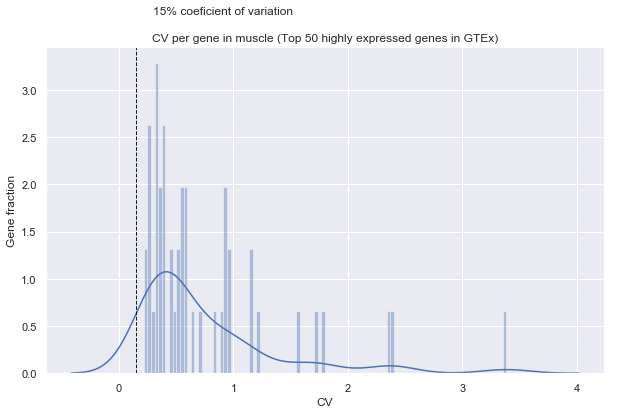

In [54]:
ax = sns.distplot(coef_variation[coef_variation['symbol'].isin(highly_expressed_genes_muscle)]['coef_var'],bins=100)
plt.title("CV per gene in muscle (Top 50 highly expressed genes in GTEx)")
plt.xlabel("CV")
plt.ylabel("Gene fraction")

# add vertical line
plt.axvline(0.15, color='k', linestyle='dashed', linewidth=1)
plt.text(0.3,3.8,'15% coeficient of variation')
fig = plt.gcf()
fig.set_size_inches(10, 6)

In [55]:
df_valid = filter_data(y_pred_valid, y_muscle_valid, meta_valid['Individual'].drop_duplicates().tolist(), high_variation_genes[:12], gtex.genes, meta_valid)
df_train = filter_data(y_pred_train, y_muscle_train, meta_train['Individual'].drop_duplicates().tolist(), high_variation_genes[:12], gtex.genes, meta_train)

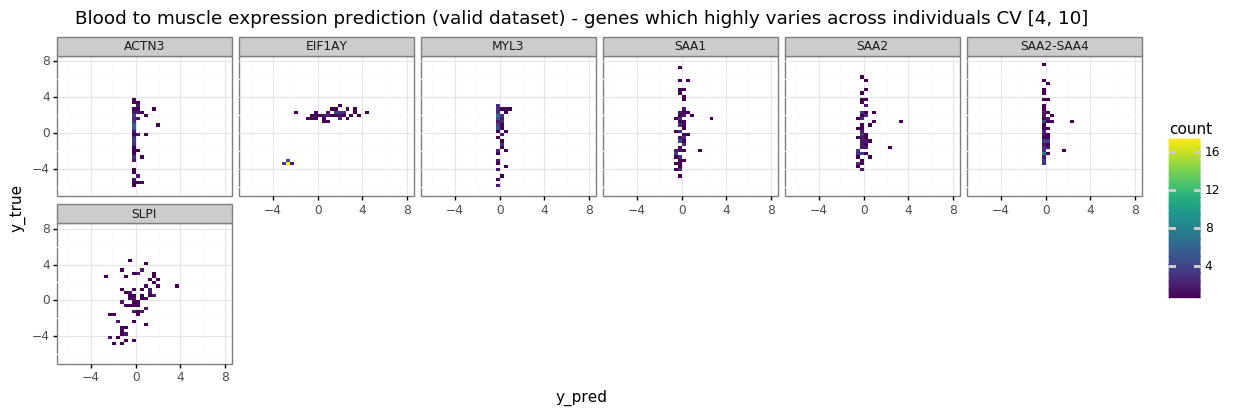

<ggplot: (8768678013227)>

In [56]:
plot_expression_correlation_per_gene(df_valid,'Blood to muscle expression prediction (valid dataset) - genes which highly varies across individuals CV [4, 10]', height_=4, width_ = 14)

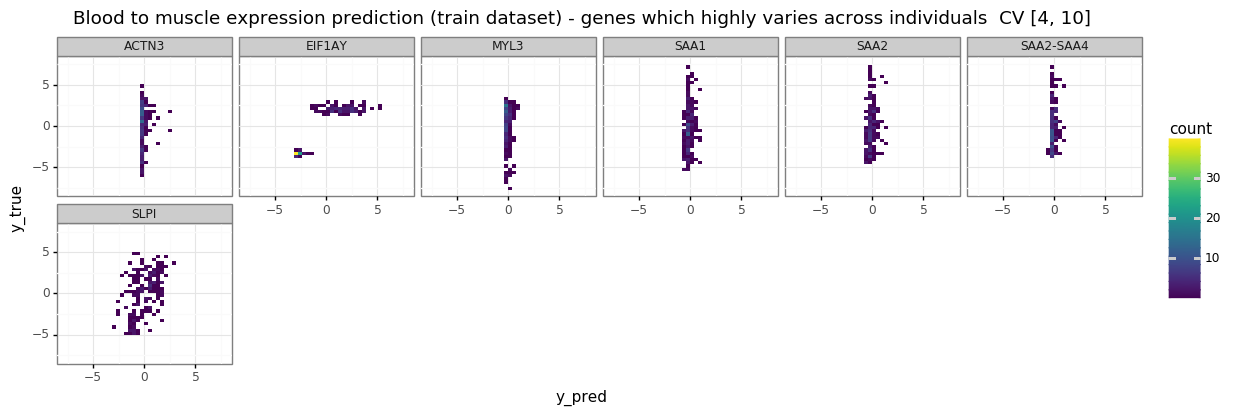

<ggplot: (8768677171078)>

In [57]:
plot_expression_correlation_per_gene(df_train,'Blood to muscle expression prediction (train dataset) - genes which highly varies across individuals  CV [4, 10]', height_=4, width_ = 14)

### 1.2.1 Genes with Low CV - good prediction

In [108]:
#  genes with CV < 0.005
low_variation_genes = coef_variation[(coef_variation['coef_var']<=3) & (coef_variation['coef_var']>1)]['gene_id'].tolist()
len(low_variation_genes)

269

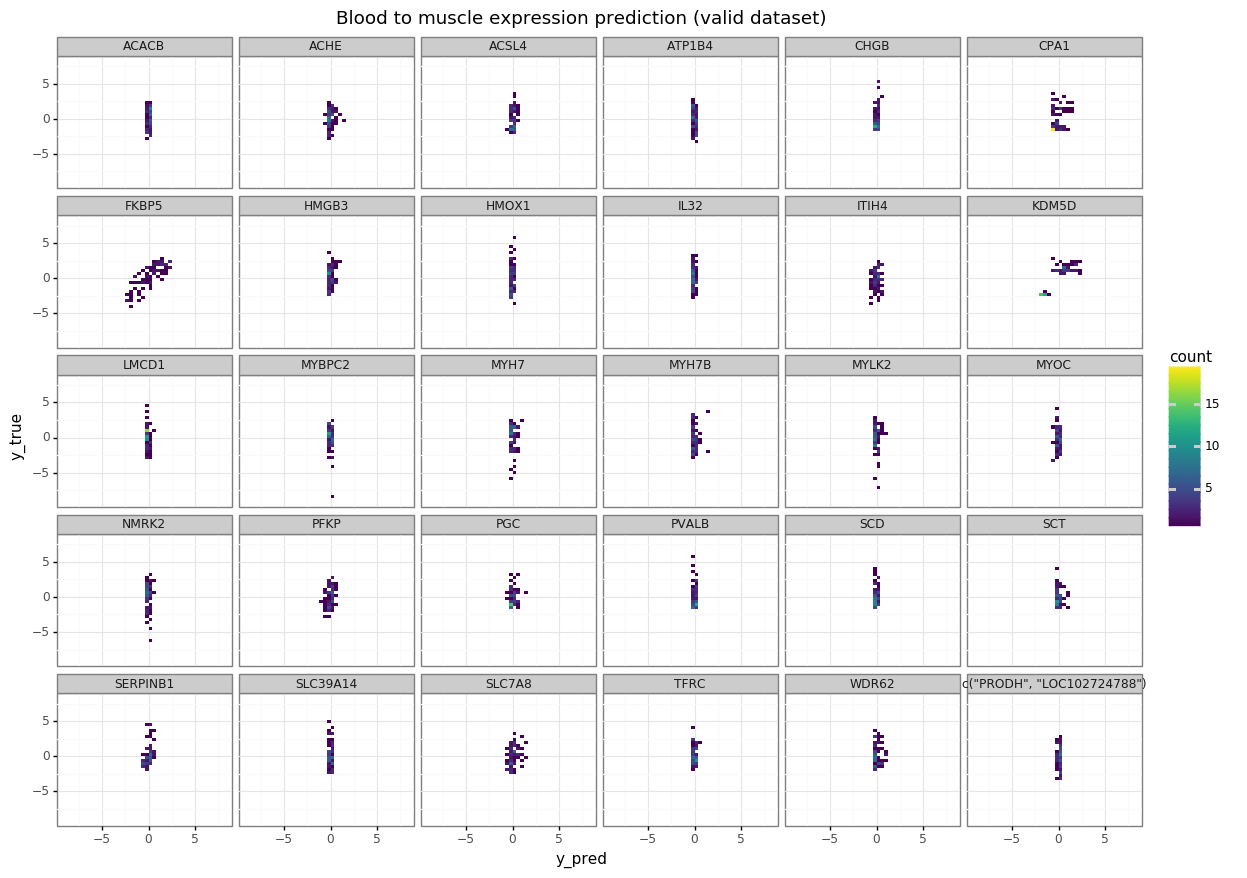

<ggplot: (-9223363268222005844)>

In [111]:
df_valid = filter_data(y_pred_valid, y_muscle_valid, meta_valid['Individual'].drop_duplicates().tolist(), low_variation_genes[:30], gtex.genes, meta_valid)
df_train = filter_data(y_pred_train, y_muscle_train, meta_train['Individual'].drop_duplicates().tolist(), low_variation_genes[:30], gtex.genes, meta_train)
plot_expression_correlation_per_gene(df_valid,'Blood to muscle expression prediction (valid dataset)', height_= 10, width_ = 14)

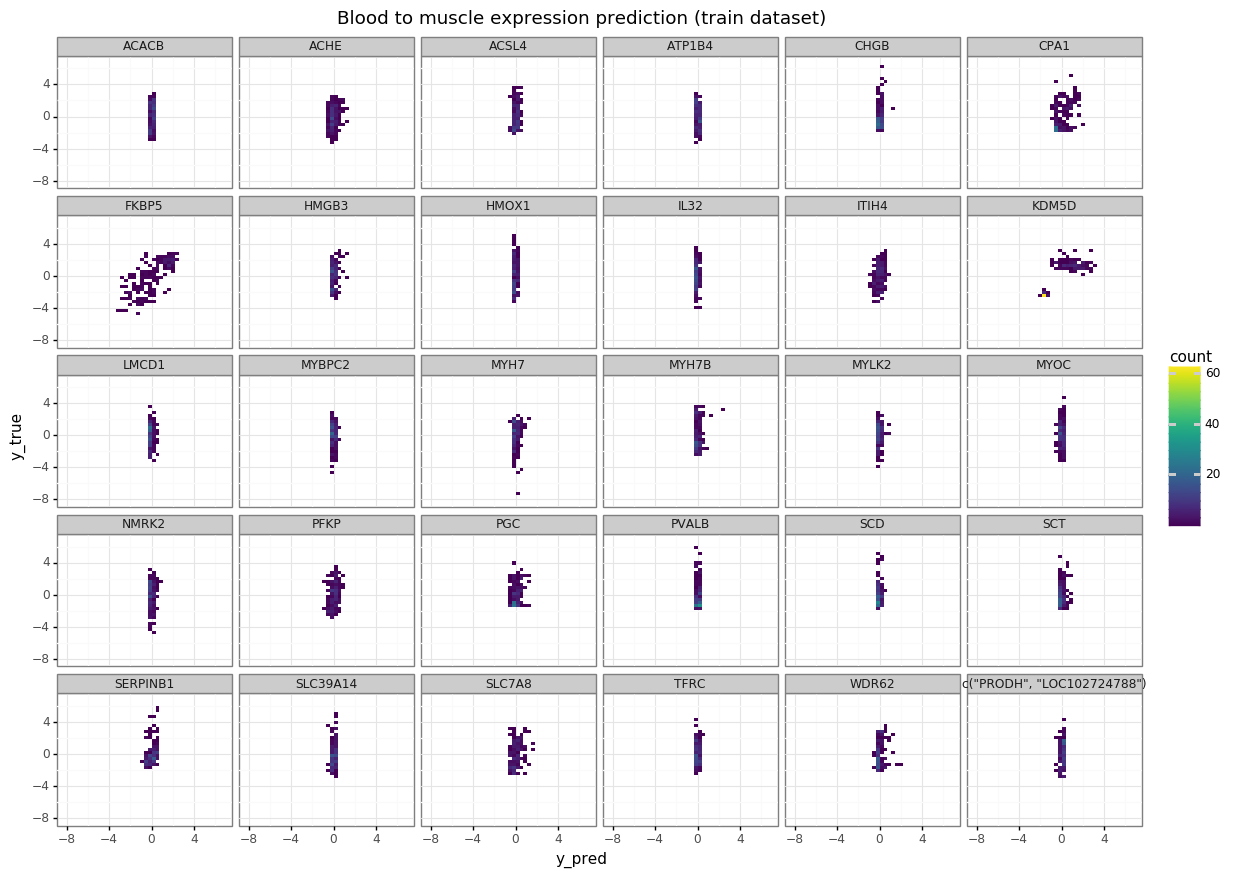

<ggplot: (8768633610816)>

In [112]:
plot_expression_correlation_per_gene(df_train,'Blood to muscle expression prediction (train dataset)', height_= 10, width_ = 14)

<br/>

#### 1.3 Correlation between Pred and Observed for genes highly enriched in muscle skeletal according to GTEx top 50 (pick only the tissue specific genes)
'EEF1A2', 'MYBPC1', 'TNNT1', 'RP11-451G4.2', 'ATP2A1', 'MYLPF', 'MYL1', 'MYH1', 'TNNI2', <br/>
'TNNT3', 'MYOZ1', 'STAC3', 'CA3', 'TNNC2', 'ACTN2', 'PYGM', 'SLN', 'NRAP', 'KLHL41',  <br/>
'COX6A2', 'MYH7', 'ENO3', 'TNNC1', 'TCAP', 'ACTA1', 'MYL2', 'MB', 'CKM' <br/>
are genes enriched in muscle - skeletal. 

In [58]:
genes_tissue_specific = ['EEF1A2', 'MYBPC1', 'TNNT1', 'RP11-451G4.2', 'ATP2A1', 'MYLPF', 'MYL1', 'MYH1', 'TNNI2', 'TNNT3', 'MYOZ1', 'STAC3', 'CA3', 'TNNC2', 'ACTN2', 'PYGM', 'SLN', 'NRAP', 'KLHL41', 'COX6A2', 'MYH7', 'ENO3', 'TNNC1', 'TCAP', 'ACTA1', 'MYL2', 'MB', 'CKM']
features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
gtex = prep.RepAnnData.read_h5ad(features_file)
genes2ensembl = gtex.genes[gtex.genes['symbol'].isin(genes_tissue_specific)]['gene_id'].tolist()

In [59]:
df_valid = filter_data(y_pred_valid, y_muscle_valid, meta_valid['Individual'].drop_duplicates().tolist(), genes2ensembl, gtex.genes, meta_valid)
df_train = filter_data(y_pred_train, y_muscle_train, meta_train['Individual'].drop_duplicates().tolist(), genes2ensembl, gtex.genes, meta_train)

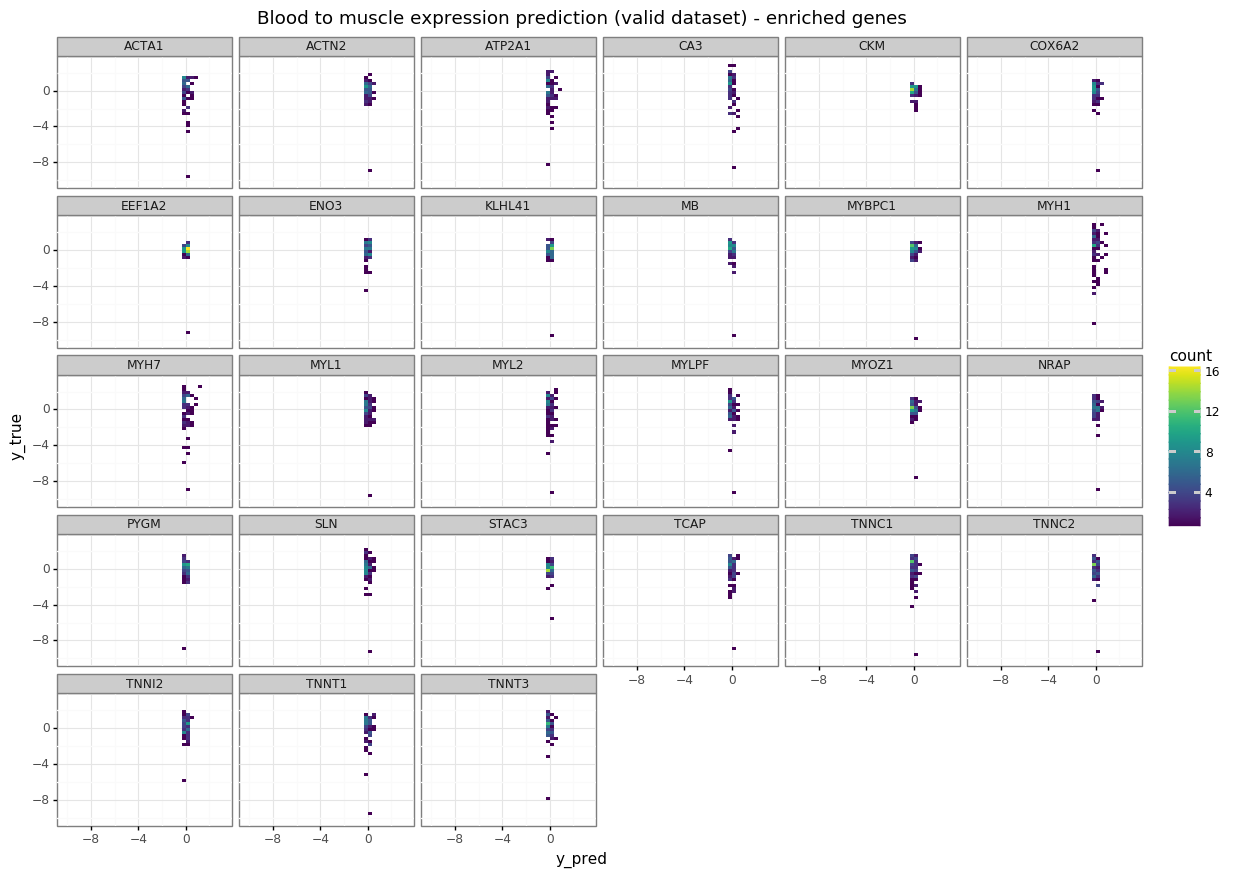

<ggplot: (8768678272148)>

In [60]:
plot_expression_correlation_per_gene(df_valid,'Blood to muscle expression prediction (valid dataset) - enriched genes', height_ = 10)

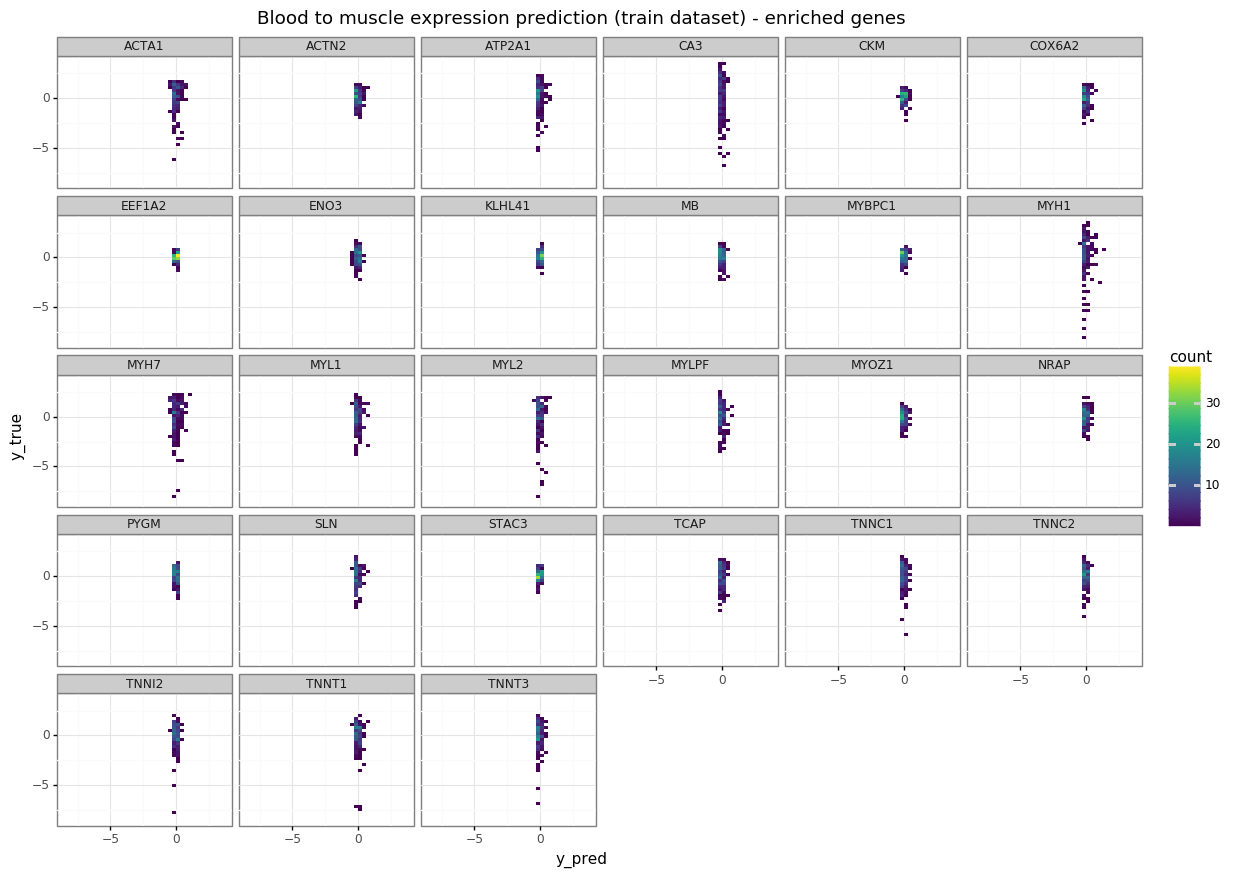

<ggplot: (-9223363268176315118)>

In [61]:
plot_expression_correlation_per_gene(df_train,'Blood to muscle expression prediction (train dataset) - enriched genes', height_ = 10)

In [63]:
for key in mse_valid_dict:
    if key in genes2ensembl:
        i = genes2ensembl.index(key)
        print(f'{genes_tissue_specific[i]}({key}) have var =',mse_valid_dict[key]['true_var'])

EEF1A2(ENSG00000068976.13) have var = 1.510226
MYBPC1(ENSG00000077522.12) have var = 1.5851874
TNNT1(ENSG00000092054.12) have var = 4.052654
RP11-451G4.2(ENSG00000101210.10) have var = 1.2994928
ATP2A1(ENSG00000101470.9) have var = 2.0142708
MYLPF(ENSG00000104879.4) have var = 1.7383778
MYL1(ENSG00000105048.16) have var = 2.6421306
MYH1(ENSG00000108515.17) have var = 0.9367048
TNNI2(ENSG00000109061.9) have var = 4.291046
TNNT3(ENSG00000111245.14) have var = 3.4327984
MYOZ1(ENSG00000114854.7) have var = 2.5777254
STAC3(ENSG00000130595.16) have var = 1.7193543
CA3(ENSG00000130598.15) have var = 1.2263085
TNNC2(ENSG00000143632.14) have var = 3.1641998
ACTN2(ENSG00000156885.5) have var = 1.6499242
PYGM(ENSG00000164879.6) have var = 3.5934746
SLN(ENSG00000168530.15) have var = 2.075541
NRAP(ENSG00000170290.3) have var = 2.058268
KLHL41(ENSG00000173991.5) have var = 2.4034941
COX6A2(ENSG00000177791.11) have var = 1.0882053
MYH7(ENSG00000180209.11) have var = 2.3585606
ENO3(ENSG00000185482.7)

### 1.5 Genes distribution per individual

In [64]:
df_valid = filter_data(y_pred_valid, y_muscle_valid, meta_valid['Individual'].drop_duplicates().tolist()[:10], gtex.genes['gene_id'].tolist(), gtex.genes, meta_valid)
df_train = filter_data(y_pred_train, y_muscle_train, meta_train['Individual'].drop_duplicates().tolist()[:10], gtex.genes['gene_id'].tolist(), gtex.genes, meta_train)

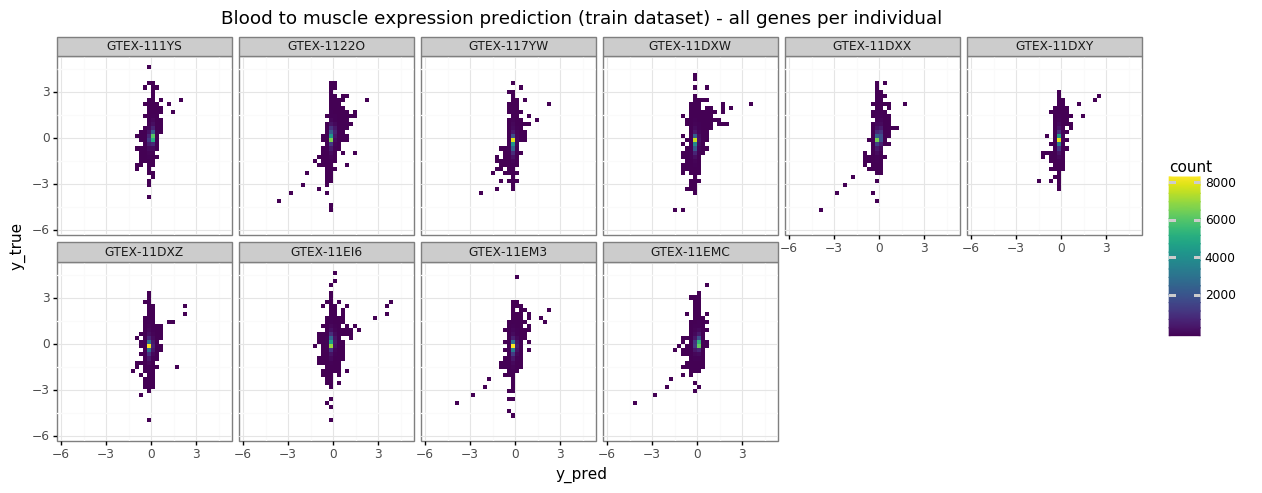

<ggplot: (-9223363268221838490)>

In [65]:
plot_expression_correlation_per_individual(df_train,'Blood to muscle expression prediction (train dataset) - all genes per individual', height_ = 5)

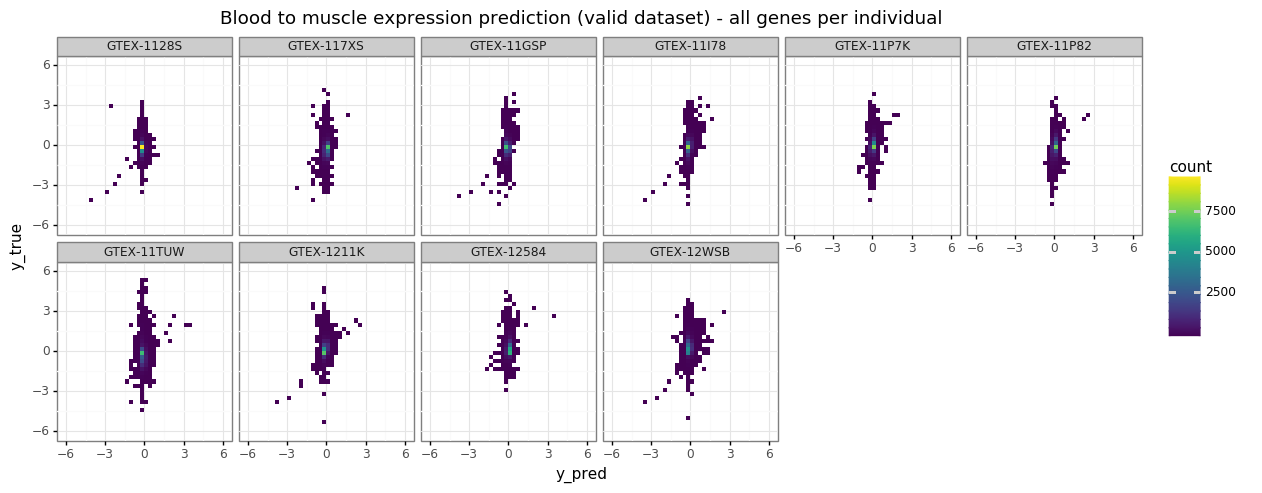

<ggplot: (8768677117055)>

In [66]:
plot_expression_correlation_per_individual(df_valid,'Blood to muscle expression prediction (valid dataset) - all genes per individual', height_ = 5)

#### 1.5.1 Determine genes which correlate for Obs/Pred and have a high FC

In [87]:
df_valid[(df_valid['y_true']<-2) & (df_valid['y_pred']<-2)]

,y_true,y_pred,Individual,Gene
988,-2.937457,-2.246640,GTEX-1128S,DDX3Y
6103,-4.073043,-4.229468,GTEX-1128S,RPS4Y1
16876,-3.416363,-2.927048,GTEX-1128S,EIF1AY
21972,-3.324380,-2.349172,GTEX-117XS,FKBP5
40852,-2.944606,-2.100725,GTEX-11GSP,DDX3Y
45967,-3.815421,-3.877702,GTEX-11GSP,RPS4Y1
56740,-3.441704,-2.815746,GTEX-11GSP,EIF1AY
65899,-4.047009,-3.586019,GTEX-11I78,RPS4Y1
76672,-3.349380,-2.861420,GTEX-11I78,EIF1AY
140512,-2.704587,-2.090498,GTEX-1211K,DDX3Y


In [88]:
df_valid[(df_valid['y_true']>2) & (df_valid['y_pred']>2)]

,y_true,y_pred,Individual,Gene
96604,2.230508,2.018308,GTEX-11P7K,EIF1AY
105763,2.343420,2.595681,GTEX-11P82,RPS4Y1
116536,2.074714,2.285630,GTEX-11P82,EIF1AY
120580,2.525395,2.412259,GTEX-11TUW,DDX3Y
125695,2.089067,3.404258,GTEX-11TUW,RPS4Y1
141564,2.156460,2.216117,GTEX-1211K,FKBP5
176332,2.599015,3.563633,GTEX-12584,EIF1AY
186142,2.843908,2.684628,GTEX-12WSB,GSTM1


#### 1.5.2 Who are:
- RPS4Y1  ('ENSG00000129824.15')
- FKBP5 ('ENSG00000096060.14')
- GSTM1 ('ENSG00000134184.12')
- DDX3Y ('ENSG00000067048.16')

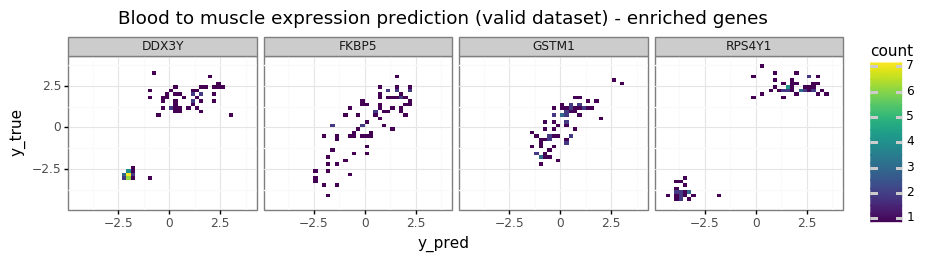

<ggplot: (-9223363268189102062)>

In [90]:
features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
gtex = prep.RepAnnData.read_h5ad(features_file)
df_valid_ = filter_data(y_pred_valid, y_muscle_valid, meta_valid['Individual'].drop_duplicates().tolist(), ['ENSG00000129824.15','ENSG00000096060.14', 'ENSG00000134184.12', 'ENSG00000067048.16'], gtex.genes, meta_valid)
plot_expression_correlation_per_gene(df_valid_,'Blood to muscle expression prediction (valid dataset) - genes with nice prediction', height_ = 2, width_ = 10)

In [113]:
genes2ensembl = ['ENSG00000129824.15','ENSG00000096060.14', 'ENSG00000134184.12', 'ENSG00000067048.16']
genes_tissue_specific = ['RPS4Y1','FKBP5', 'GSTM1', 'DDX3Y']
for key in mse_valid_dict:
    if key in genes2ensembl:
        i = genes2ensembl.index(key)
        print(f'{genes_tissue_specific[i]}({key}) have var =',mse_valid_dict[key]['true_var'])

DDX3Y(ENSG00000067048.16) have var = 5.2504497
FKBP5(ENSG00000096060.14) have var = 2.9094489
RPS4Y1(ENSG00000129824.15) have var = 9.960213
GSTM1(ENSG00000134184.12) have var = 1.3868427


<br/>

#### 1.6 Check ENSG00000111536.4 (IL26) if the data its correct

In [69]:
# this is the data predicted
df = df_valid[df_valid['Gene'] == 'IL26'].iloc[-10:,:]
indiv = df['Individual'].tolist()
df

,y_true,y_pred,Individual,Gene
3871,-0.014867,-0.081949,GTEX-1128S,IL26
23803,-0.014867,0.025229,GTEX-117XS,IL26
43735,-0.014867,-0.017113,GTEX-11GSP,IL26
63667,-0.014867,-0.052025,GTEX-11I78,IL26
83599,-0.008381,0.015668,GTEX-11P7K,IL26
103531,-0.014867,0.006720,GTEX-11P82,IL26
123463,-0.014867,-0.060999,GTEX-11TUW,IL26
143395,-0.014867,-0.042891,GTEX-1211K,IL26
163327,-0.014867,0.043052,GTEX-12584,IL26
183259,-0.014867,-0.052624,GTEX-12WSB,IL26


In [70]:
# this is the original data - check if the parsing of the data was correct
features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
gtex = prep.RepAnnData.read_h5ad(features_file)
gtex = gtex[gtex.samples['Tissue'] == 'Muscle - Skeletal']
gtex_gene = gtex[:,'ENSG00000111536.4']

In [71]:
pd.DataFrame(data={'Value': gtex_gene[gtex_gene.obs['Individual'].isin(indiv)].X,
                    'Individual':gtex_gene[gtex_gene.obs['Individual'].isin(indiv)].obs['Individual'].tolist()})

,Value,Individual
0,-0.014877,GTEX-11GSP
1,-0.014877,GTEX-11P82
2,-0.014877,GTEX-12WSB
3,-0.014877,GTEX-117XS
4,-0.014877,GTEX-12584
5,-0.008391,GTEX-11P7K
6,-0.014877,GTEX-11TUW
7,-0.014877,GTEX-11I78
8,-0.014877,GTEX-1128S
9,-0.014877,GTEX-1211K


### 1.7 Highly expressed genes profile
We compare here what is the effect if we change our set of features (instead of using all 20000 genes) we use only the 39 genes which we consider to be highly expressed.
For each setup we run the Coordinate Descent using: <br/>
(a) Ridge Regression + loss function = MSE <br/>
(b) Huber Regression + loss function = MSE <br/>
(c) Ridge Regression + loss function = MAPE (mean absolute percentage error)

We will also focus for individuals that have actually a negative/positive change with respect to the population ['GTEX-WY7C', 'GTEX-14A6H', 'GTEX-P4PP', 'GTEX-POMQ', 'GTEX-WY7C', 'GTEX-PSDG', 'GTEX-12WSJ']

In [24]:
from joblib import dump, load
import numpy as np
import pandas as pd

from rep import models_coord_descent as m
from rep import constants as cst
from rep import linear_regression as lr
from rep import preprocessing_new as prep

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [44]:
import plotnine as gg
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np

def _check_plotnine_grid(plots_list, figsize):
        if not type(plots_list) == list:
            raise ValueError('Input plots_list is not a list')
        if (not type(figsize) == tuple) or (not len(figsize) == 2):
            raise ValueError('Input figsize should be a tuple of length 2')


def plotnine_grid(plots_list, row=None, col=1, height=None, width=None, dpi=500, ratio=None, pixels=10000,
                  figsize=(12, 8)):

    """
    Create a grid of plotnine plots.


    Function input
    ----------
    plots_list      : a list of plotnine.ggplots
    row, col        : numerics to indicate in how many rows and columns the plots should be ordered in the grid
                      defaults: row -> length of plots_list; col -> 1
    height, width   : the height and width of the individual subplots created by plotnine
                        can be automatically determined by a combination of dpi, ratio and pixels
    dpi             : the density of pixels in the image. Default: 500. Higher numbers could lead to crisper output,
                        depending on exact situation
    ratio           : the ratio of heigth to width in the output. Standard value is 1.5 x col/row.
                        Not used if height & width are given.
    pixels          : the total number of pixels used, default 10000. Not used if height & width are given.
    figsize         : tuple containing the size of the final output after making a grid, in pixels (default: (1200,800))



    Function output
    ----------
    A matplotlib figure that can be directly saved with output.savefig().
    """

    _check_plotnine_grid(plots_list, figsize)  # Check the input

    # Assign values that have not been provided based on others. In the end, height and width should be provided.
    if row is None:
        row = len(plots_list)

    if ratio is None:
        ratio = 1.5 * col / row

    if height is None and width is not None:
        height = ratio * width

    if height is not None and width is None:
        width = height / ratio

    if height is None and width is None:
        area = pixels / dpi
        width = np.sqrt(area/ratio)
        height = ratio * width

    # Do actual subplot creation and plot output.
    i = 1
    fig = plt.figure(figsize=figsize)
    plt.autoscale(tight=True)
    for image_sel in plots_list:  # image_sel = plots_list[i]
#         image_sel.save('image' + str(i) + '.png', height=height, width=width, dpi=500, verbose=False)
        fig.add_subplot(row, col, i)
#         plt.imshow(img.imread('image' + str(i) + '.png'), aspect='auto')
        fig.tight_layout()
        fig.get_axes()[i-1].axis('off')
        i = i + 1
#         os.unlink('image' + str(i - 1) + '.png')  # os.unlink is basically os.remove but in some cases quicker
    fig.patch.set_visible(False)
    return fig

(83, 19932)
(220, 19932)
(83, 19932)
(220, 19932)
(83, 19932)
(220, 19932)


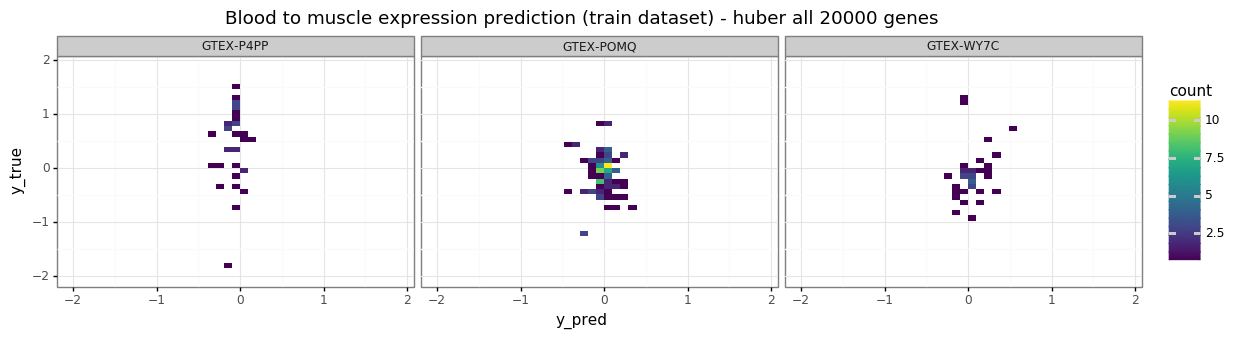

<ggplot: (-9223363291695616624)>

In [61]:
path_models = "/s/project/rep/processed/models/linear_regression/"
dict_models = {'huber all 20000 genes':f'{path_models}blood2muscle_skeletal_coord_descent_huber.joblib',
              'ridge all 20000 genes':f'{path_models}blood2muscle_skeletal_coord_descent_ridge.joblib',
              'MAPE loss all 20000 genes':f'{path_models}blood2muscle_skeletal_coord_descent_l1_loss.joblib'
              }

high_expressed_genes = prep.load_list("/s/project/rep/processed/gtex/input_data/genes_subset/highly_expressed_genes.txt")

# this is the original data - check if the parsing of the data was correct
features_file = "/s/project/rep/processed/gtex/recount/recount_gtex_logratios.h5ad"
gtex = prep.RepAnnData.read_h5ad(features_file)

plot_list = []

for key in dict_models:

    model = load(dict_models[key])    
    (y_blood_train, y_muscle_train, meta_train, P_train_u, Q_u, n_genes_train, n_indiv_train), (y_blood_valid, y_muscle_valid, meta_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input('Muscle - Skeletal',
                                                                                                                                                                                                                n_comp_indiv_effect=25,
                                                                                                                                                                                                                n_comp_gene_effect=25,
                                                                                                                                                                                                                gene_list=None)
    y_pred_valid = m.predict_model4(model, y_blood_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid)
    y_pred_train = m.predict_model4(model, y_blood_train, P_train_u, Q_u, n_genes_train, n_indiv_train)

    y_pred_train = y_pred_train.astype(np.float32)
    y_pred_valid = y_pred_valid.astype(np.float32)

    df_valid = filter_data(y_pred_valid, y_muscle_valid, ['GTEX-WY7C', 'GTEX-14A6H', 'GTEX-P4PP', 'GTEX-POMQ'] + ['GTEX-WY7C', 'GTEX-PSDG', 'GTEX-12WSJ'], high_expressed_genes, gtex.genes, meta_valid)
    df_train = filter_data(y_pred_train, y_muscle_train, ['GTEX-WY7C', 'GTEX-14A6H', 'GTEX-P4PP', 'GTEX-POMQ'] + ['GTEX-WY7C', 'GTEX-PSDG', 'GTEX-12WSJ'], high_expressed_genes, gtex.genes, meta_train)
    p = plot_expression_correlation_per_individual(df_train,'Blood to muscle expression prediction (train dataset) - ' + key, height_ = 3)
    plot_list.append(p)
    
plot_list[0]

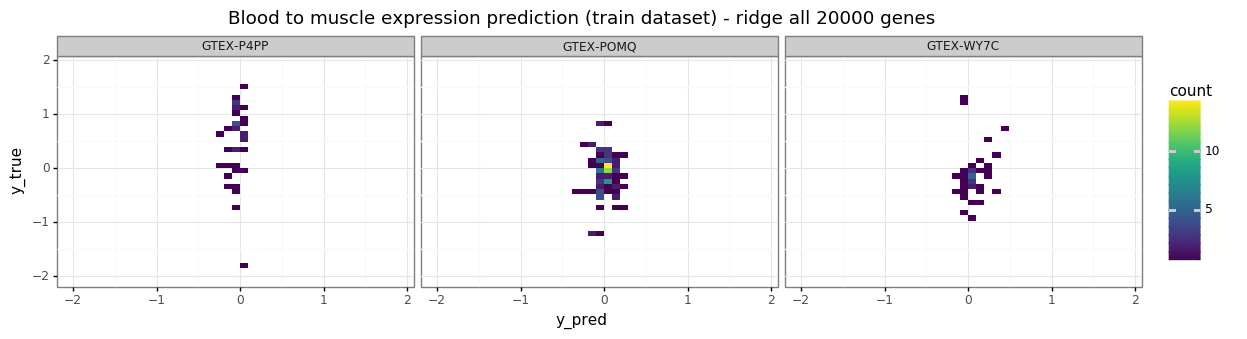

<ggplot: (8745025507364)>

In [62]:
plot_list[1]

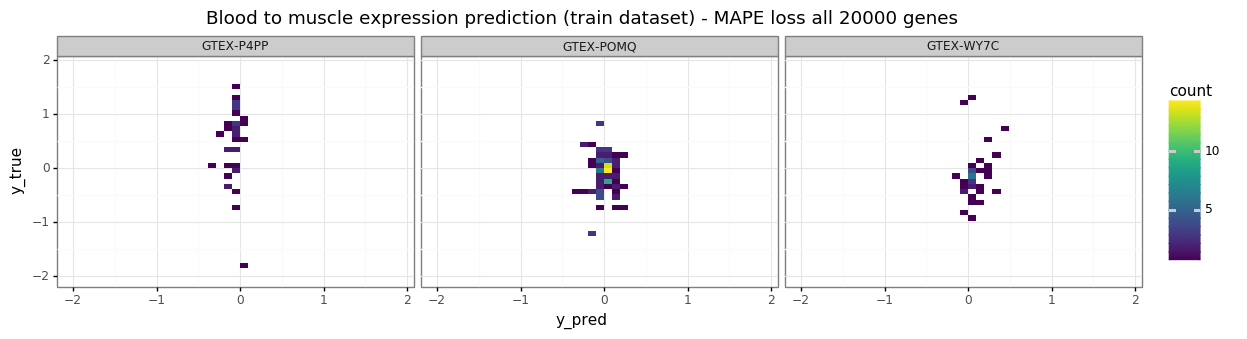

<ggplot: (-9223363291694884741)>

In [63]:
plot_list[2]

(83, 39)
(220, 39)
(83, 39)
(220, 39)
(83, 39)
(220, 39)


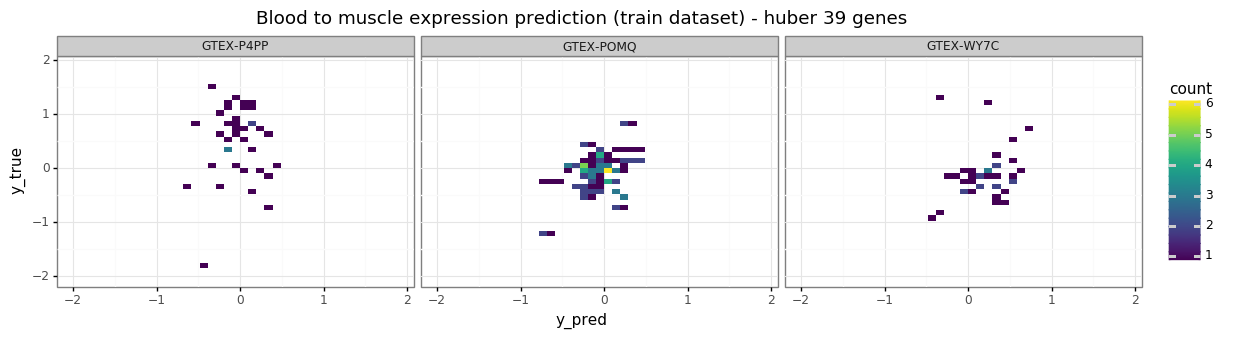

<ggplot: (8745115662056)>

In [65]:
path_models = "/s/project/rep/processed/models/linear_regression/"
model = load(f'{path_models}blood2muscle_skeletal_coord_descent_high_expressed_huber.joblib')

dict_models = {'huber 39 genes':f'{path_models}blood2muscle_skeletal_coord_descent_high_expressed_huber.joblib',
              'ridge 39 genes':f'{path_models}blood2muscle_skeletal_coord_descent_high_expressed_ridge.joblib',
              'MAPE 39 genes':f'{path_models}blood2muscle_skeletal_coord_descent_high_expressed_l1_loss.joblib'}

high_expressed_genes = prep.load_list("/s/project/rep/processed/gtex/input_data/genes_subset/highly_expressed_genes.txt")
# this is the original data - check if the parsing of the data was correct
features_file = "/s/project/rep/processed/gtex/recount/recount_gtex_logratios.h5ad"
gtex = prep.RepAnnData.read_h5ad(features_file)
gtex_filtered = prep.RepAnnData.filter_genes(gtex,key='gene_id',values=high_expressed_genes)

plot_list = []

for key in dict_models:
    model = load(dict_models[key])  
    (y_blood_train, y_muscle_train, meta_train, P_train_u, Q_u, n_genes_train, n_indiv_train), (y_blood_valid, y_muscle_valid, meta_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input('Muscle - Skeletal',
                                                                                                                                                                                                                n_comp_indiv_effect=25,
                                                                                                                                                                                                                n_comp_gene_effect=25,
                                                                                                                                                                                                                gene_list=high_expressed_genes)
    y_pred_valid = m.predict_model4(model, y_blood_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid)
    y_pred_train = m.predict_model4(model, y_blood_train, P_train_u, Q_u, n_genes_train, n_indiv_train)

    y_pred_train = y_pred_train.astype(np.float32)
    y_pred_valid = y_pred_valid.astype(np.float32)

    df_valid = filter_data(y_pred_valid, y_muscle_valid, ['GTEX-WY7C', 'GTEX-14A6H', 'GTEX-P4PP', 'GTEX-POMQ'] + ['GTEX-WY7C', 'GTEX-PSDG', 'GTEX-12WSJ'], high_expressed_genes, gtex_filtered.genes, meta_valid)
    df_train = filter_data(y_pred_train, y_muscle_train, ['GTEX-WY7C', 'GTEX-14A6H', 'GTEX-P4PP', 'GTEX-POMQ'] + ['GTEX-WY7C', 'GTEX-PSDG', 'GTEX-12WSJ'], high_expressed_genes, gtex_filtered.genes, meta_train)
    p = plot_expression_correlation_per_individual(df_train,'Blood to muscle expression prediction (train dataset) - ' + key, height_ = 3)
    plot_list.append(p)
    
plot_list[0]

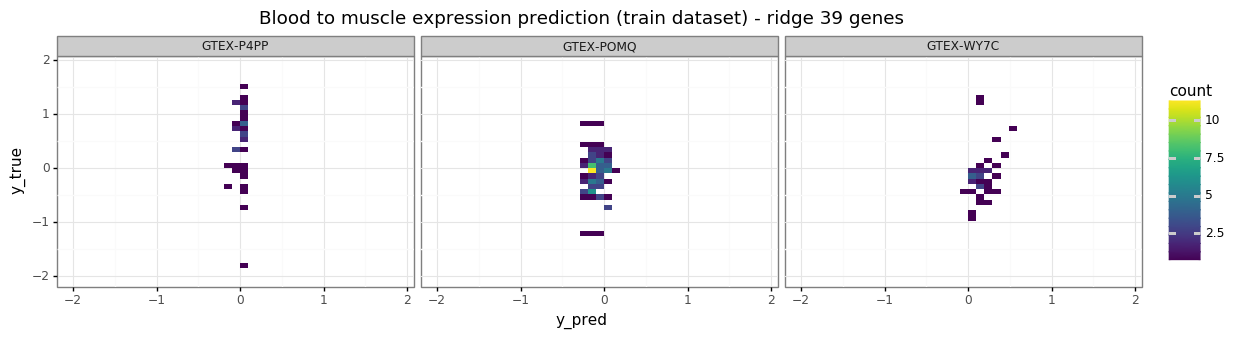

<ggplot: (8745114077553)>

In [66]:
plot_list[1]

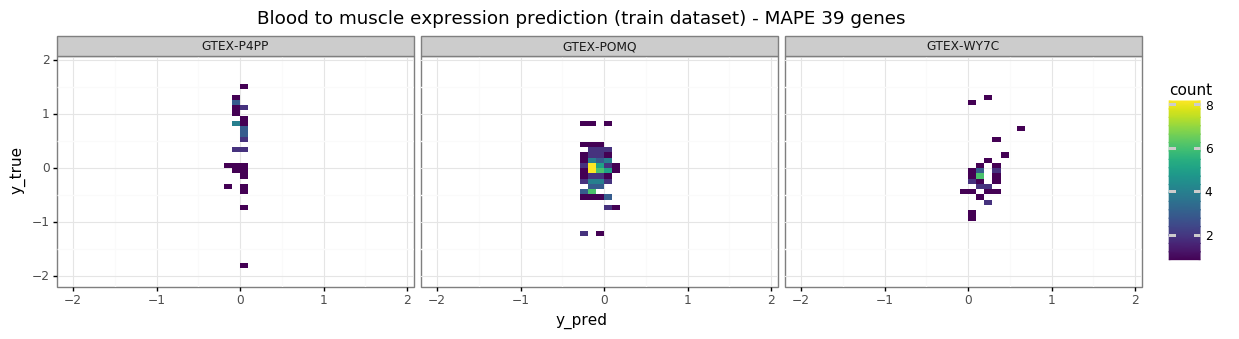

<ggplot: (-9223363291756210151)>

In [67]:
plot_list[2]

<br/>

### 2. Performance summary of different models for top 3 Tissues
Models:
- `model4` = coordinative fitting using loss_function = mse (mean squared error), estimator = RigdeRegressor
- `l1_loss` = coordinative fitting using loss_function = lad (least absolute deviations), estimator = RidgeRegressor
- `huber` = coordinative fitting using loss_function = mse (mean squared error), estimator = HuberRegressor
- all models above with the difference that the Q matrix is now computed using the TPMs and not the logRatio values
- `model2` = linear fit for each gene using RidgeRegressor


In [9]:
from joblib import dump, load
import numpy as np
import pandas as pd

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

import pickle
from IPython.display import display, HTML

path_models = "/s/project/rep/processed/models/linear_regression/"
models = {
          'model4 using Q with TPMs (n_comp_Q=10, n_comp_P=10)':f'{path_models}evaluation_tissues_model4_Q_tpm.json',
          'model4 using Q with TPMs (n_comp_Q=26, n_comp_P=95)':f'{path_models}evaluation_tissues_model4_optimal.json',
#           'model4 using Q with log_ratios (n_comp_Q=10, n_comp_P=10)':f'{path_models}evaluation_tissues_model4_new.json',
          'l1_loss using Q with TPMs (n_comp_Q=10, n_comp_P=10)':f'{path_models}evaluation_tissues_l1_loss_Q_tmp.json',
#           'l1_loss using Q with log ratios':f'{path_models}evaluation_tissues_l1_loss.json',
#           'huber_regression using Q with TPMs':f'{path_models}evaluation_tissues_huber_regression_Q_tmp.json',
          'huber_regression using Q with TPM (n_comp_Q=26, n_comp_P=95)':f'{path_models}evaluation_tissues_huber_regression_optimal.json',
         'model 4 kernelPCA':f'{path_models}evaluation_tissues_model4_Q_tpm_kernelpca.json',
         'l1_loss kernelPCA':f'{path_models}evaluation_tissues_l1_loss_Q_tmp_kernelpca.json',
         'huber_regression kernelPCA':f'{path_models}evaluation_tissues_huber_regression_Q_tmp_kernelpca.json',
         'coord_descent_high_expressed_ridge (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_high_expressed_ridge_pca25.json',    
         'coord_descent_high_expressed_huber (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_high_expressed_huber_pca25.json',
         'coord_descent_high_expressed_l1_loss (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_high_expressed_l1_loss_pca25.json',
         'coord_descent_ridge (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_ridge_pca25.json',    
         'coord_descent_huber (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_pca25.json',
         'coord_descent_l1_loss (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_l1_loss_pca25.json',
         'simple model raw tpm l1_loss': f'{path_models}model2_l1_loss_pca25_logtpm.json',
         'simple model raw tpm huber': f'{path_models}model2_huber_pca25_logtpm.json',
         'simple model raw tpm ridge': f'{path_models}model2_ridge_pca25_logtpm.json',
#           'coord_descent_ridge raw tpm (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_ridge_pca25_log_tpm.json',    
#          'coord_descent_huber raw tpm (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_pca25_log_tpm.json',
#          'coord_descent_l1_loss raw tpm (n_comp_Q=25, n_comp_P=25)':f'{path_models}coord_descent_l1_loss_pca25_log_tpm.json',
        
        }
dict_evaluation = pickle.load(open(f'{path_models}evaluation_tissues_model4.json', "rb"))

In [10]:
for m in models:
    dict_evaluation = pickle.load(open(models[m], "rb")) 
    df_summary = pd.DataFrame(columns = ['Tissue','train_loss','valid_loss','valid_mse_median','valid_pearson_median','valid_spearman_median','valid_mse_mean','valid_pearson_mean', 'valid_spearman_mean'])
    for key in dict_evaluation:
        for tissue in dict_evaluation[key]:
            df_summary = df_summary.append({'Tissue':tissue,
                               'train_loss':dict_evaluation[key][tissue]['train']['loss'],
#                                'train_mse_median':dict_evaluation[key][tissue]['train']['metrics']['mse']['median'],
#                                'train_pearson_median':dict_evaluation[key][tissue]['train']['metrics']['pearsonr']['median'],
#                                'train_spearman_median':dict_evaluation[key][tissue]['train']['metrics']['spearmanr']['median'],
                               'valid_loss':dict_evaluation[key][tissue]['valid']['loss'],
                               'valid_mse_median':dict_evaluation[key][tissue]['valid']['metrics']['mse']['median'],
                               'valid_pearson_median':dict_evaluation[key][tissue]['valid']['metrics']['pearsonr']['median'],
                               'valid_spearman_median':dict_evaluation[key][tissue]['valid']['metrics']['spearmanr']['median'],
#                                'valid_mse_min':dict_evaluation[key][tissue]['valid']['metrics']['mse']['min'],
#                                'valid_pearson_max':dict_evaluation[key][tissue]['valid']['metrics']['pearsonr']['max'],
#                                'valid_spearman_max':dict_evaluation[key][tissue]['valid']['metrics']['spearmanr']['max'],
                               'valid_mse_mean':dict_evaluation[key][tissue]['valid']['metrics']['mse']['mean'],
                               'valid_pearson_mean':dict_evaluation[key][tissue]['valid']['metrics']['pearsonr']['mean'],
                               'valid_spearman_mean':dict_evaluation[key][tissue]['valid']['metrics']['spearmanr']['mean'],
                              },ignore_index=True)
    print(m)
    display(df_summary[:1])      

model4 using Q with TPMs (n_comp_Q=10, n_comp_P=10)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.235329,0.280599,0.202236,0.194973,0.180407,0.280599,0.198235,0.184692


model4 using Q with TPMs (n_comp_Q=26, n_comp_P=95)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.223196,0.388155,0.311559,0.003709,0.024856,0.388155,0.011979,0.029977


l1_loss using Q with TPMs (n_comp_Q=10, n_comp_P=10)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.235128,0.281238,0.202707,0.184801,0.165932,0.281238,0.191259,0.175122


huber_regression using Q with TPM (n_comp_Q=26, n_comp_P=95)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.223119,0.389089,0.312105,0.004536,0.026265,0.389089,0.013453,0.031819


model 4 kernelPCA


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.235329,0.280599,0.202239,0.194948,0.180392,0.280599,0.198226,0.184685


l1_loss kernelPCA


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.235128,0.281239,0.202708,0.184787,0.165932,0.281239,0.191251,0.175119


huber_regression kernelPCA


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.23643,0.283037,0.204513,0.181647,0.173817,0.283037,0.19112,0.184109


coord_descent_high_expressed_ridge (n_comp_Q=25, n_comp_P=25)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.259513,0.438212,0.310812,0.030097,0.129796,0.438212,0.037765,0.10775


coord_descent_high_expressed_huber (n_comp_Q=25, n_comp_P=25)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.312849,0.481359,0.339856,0.099583,0.171288,0.481359,0.099983,0.139022


coord_descent_high_expressed_l1_loss (n_comp_Q=25, n_comp_P=25)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.258275,0.427435,0.305295,0.054167,0.146588,0.427435,0.059958,0.119532


coord_descent_ridge (n_comp_Q=25, n_comp_P=25)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.233056,0.294067,0.21806,0.171428,0.185877,0.294067,0.167887,0.182497


coord_descent_huber (n_comp_Q=25, n_comp_P=25)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.234594,0.297802,0.222359,0.130755,0.165789,0.297802,0.132796,0.169181


coord_descent_l1_loss (n_comp_Q=25, n_comp_P=25)


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,0.232907,0.293218,0.217231,0.171354,0.18188,0.293218,0.168423,0.180952


simple model raw tpm l1_loss


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,29.501842,29.249429,25.443026,0.062113,0.078504,29.249431,0.070848,0.08418


simple model raw tpm huber


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,29.814666,29.48704,25.99335,0.06215,0.078512,29.487042,0.07072,0.084564


simple model raw tpm ridge


,Tissue,train_loss,valid_loss,valid_mse_median,valid_pearson_median,valid_spearman_median,valid_mse_mean,valid_pearson_mean,valid_spearman_mean
0,Muscle - Skeletal,29.501842,29.249429,25.443026,0.062113,0.078504,29.249431,0.070848,0.08418
